## Data Preparation

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models, layers, losses, metrics, callbacks 

In [7]:
path = "../data/covid-19.csv"
df = pd.read_csv(path, sep = "\t")
df.head()

,date,confirmed_num,cured_num,dead_num
0,2020-01-24,830.0,34.0,25.0
1,2020-01-25,1287.0,38.0,41.0
2,2020-01-26,1975.0,49.0,56.0
3,2020-01-27,2744.0,51.0,80.0
4,2020-01-28,4515.0,60.0,106.0


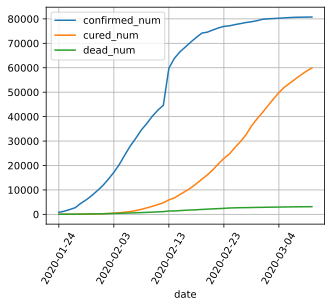

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df.plot(x = "date", y = ["confirmed_num","cured_num","dead_num"], figsize=(5,4))
plt.xticks(rotation=60)
plt.grid(True)

,confirmed_num,cured_num,dead_num
0,457.0,4.0,16.0
1,688.0,11.0,15.0
2,769.0,2.0,24.0
3,1771.0,9.0,26.0
4,1459.0,43.0,26.0


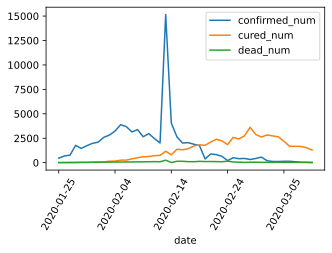

In [15]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(5,3))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date", axis = 1).astype("float32")
dfdiff.head()

In [20]:
#Use the data of an eight-day window priorier of the date we are investigating as input for prediction
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE, drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values, dtype = tf.float32)).window(
        WINDOW_SIZE, shift = 1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:], dtype = tf.float32))

#We put all data into one batch for better efficiency since the data volume is small.
ds_train = tf.data.Dataset.zip((ds_data, ds_label)).batch(38).cache()

## Model Definition

In [23]:
# We design the following block since the daily increment of confirmed, 
# discharged and deceased cases are equal or larger than zero.

class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input, x):
        print('call')
        x_out = tf.maximum((1 + x) * x_input[:,-1,:], 0.0)
        return x_out
    
    def get_config(self):        
        config = super(Block, self).get_config()
        print('config', config)
        return config

In [26]:
tf.keras.backend.clear_session()

x_input = layers.Input(shape = (None, 3), dtype = tf.float32)
x = layers.LSTM(3, return_sequences = True, input_shape=(None, 3))(x_input)
x = layers.LSTM(3, return_sequences = True, input_shape=(None, 3))(x)
x = layers.LSTM(3, return_sequences = True, input_shape=(None, 3))(x)
x = layers.LSTM(3, input_shape=(None, 3))(x)
x = layers.Dense(3)(x)

#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input, x)
print('x =',x)
print(x_input[:,-1,:])
model = models.Model(inputs = [x_input], outputs = [x])
model.summary()

call
x = Tensor("block/Maximum:0", shape=(None, 3), dtype=float32)
Tensor("strided_slice:0", shape=(None, 3), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 3)      84          input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 3)      84          lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 3)      84      

## Model Training

In [27]:
# Note: The parameter adjustment of RNN is more difficult comparing to other types of neural network. 
# We need to try various learning rate to achieve a satisfying result.

#Customized loss function, consider the ratio between square error and the prediction
class MSPE(losses.Loss):
    def call(self, y_true, y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2, 1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

In [28]:
import os
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
model.compile(optimizer=optimizer, loss = MSPE(name = "MSPE"))

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## We recommend using pathlib under Python3
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('../data/autograph/' + stamp))

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#Half the learning rate if loss is not improved after 100 epoches
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor = 0.5, patience = 100)
#Stop training when loss is not improved after 200 epoches
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train, epochs=500, callbacks = callbacks_list)

config {'name': 'block', 'trainable': True, 'dtype': 'float32'}
Epoch 1/500
call
call
1/1 [==============================] - 0s 57ms/step - loss: 3.4004
Epoch 2/500
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 21ms/step - loss: 3.0408
Epoch 3/500
1/1 [==============================] - 0s 17ms/step - loss: 2.6860
Epoch 4/500
1/1 [==============================] - 0s 18ms/step - loss: 2.3379
Epoch 5/500
1/1 [==============================] - 0s 16ms/step - loss: 2.0010
Epoch 6/500
1/1 [==============================] - 0s 17ms/step - loss: 1.6816
Epoch 7/500
1/1 [==============================] - 0s 19ms/step - loss: 1.3879
Epoch 8/500
1/1 [==============================] - 0s 17ms/step - loss: 1.1278
Epoch 9/500
1/1 [==============================] - 0s 18ms/step - loss: 0.9079
Epoch 10/500
1/1 [==============================] - 0s 17ms/step - loss: 0.7318
Epoch 11/500
1/1 [==============================] - 0s 16ms/ste

## Model Evaluation

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric])
    plt.show()

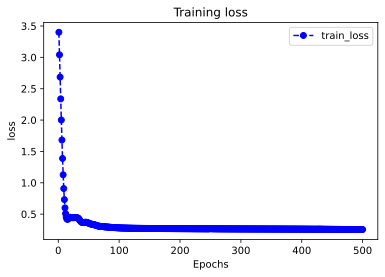

In [37]:
plot_metric(history, 'loss')

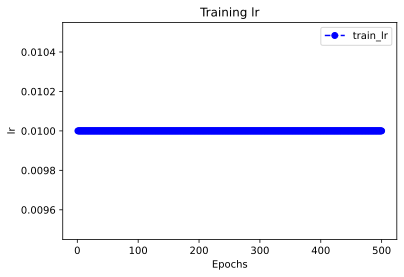

In [38]:
plot_metric(history, 'lr')

## Model Application
We predict the time of the end of COVID-19 here, i.e. the date when the daily increment of new confirmed cases = 0.

In [39]:
#This "dfresult" is used to record the current and predicted data
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [40]:
#Predicting the daily increment of the new confirmed cases of the next 100 days; add this result into dfresult
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

call


In [41]:
dfresult.query("confirmed_num==0").head()

,confirmed_num,cured_num,dead_num
48,0.0,1303.0,3.0
49,0.0,1298.0,1.0
50,0.0,1288.0,0.0
51,0.0,1272.0,0.0
52,0.0,1249.0,0.0


In [42]:
dfresult.query("cured_num==0").head()

,confirmed_num,cured_num,dead_num
97,0.0,0.0,0.0
98,0.0,0.0,0.0
99,0.0,0.0,0.0
100,0.0,0.0,0.0
101,0.0,0.0,0.0


In [43]:
dfresult.query("dead_num==0").head()

,confirmed_num,cured_num,dead_num
50,0.0,1288.0,0.0
51,0.0,1272.0,0.0
52,0.0,1249.0,0.0
53,0.0,1219.0,0.0
54,0.0,1180.0,0.0


## Model Saving

In [45]:
model.save('../data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

call
call
config {'name': 'block', 'trainable': True, 'dtype': 'float32'}
config {'name': 'block', 'trainable': True, 'dtype': 'float32'}
call
call
config {'name': 'block', 'trainable': True, 'dtype': 'float32'}
call
config {'name': 'block', 'trainable': True, 'dtype': 'float32'}
config {'name': 'block', 'trainable': True, 'dtype': 'float32'}
config {'name': 'block', 'trainable': True, 'dtype': 'float32'}
INFO:tensorflow:Assets written to: ../data/tf_model_savedmodel/assets
export saved model.


In [46]:
model_loaded = tf.keras.models.load_model('../data/tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

array([[1.01269958e+03, 9.33705063e+01, 2.66625881e+00],
       [1.24910876e+03, 7.32109680e+01, 5.42139292e+00],
       [1.36297107e+03, 1.55971191e+02, 5.06589174e+00],
       [1.55981787e+03, 1.66581467e+02, 5.68801880e+00],
       [1.87486926e+03, 2.75867401e+02, 5.77689409e+00],
       [1.78223547e+03, 2.76928436e+02, 6.48789644e+00],
       [1.51639587e+03, 4.10618011e+02, 6.48789644e+00],
       [1.63315295e+03, 5.41124512e+02, 7.64327526e+00],
       [1.27950415e+03, 6.35556030e+02, 7.90990114e+00],
       [1.43437634e+03, 6.70570007e+02, 8.62090302e+00],
       [1.19024768e+03, 7.58635376e+02, 9.59853172e+00],
       [9.72172302e+02, 7.89405212e+02, 8.62090302e+00],
       [7.30986719e+03, 1.24246436e+03, 2.25743256e+01],
       [1.95254663e+03, 8.61555115e+02, 1.15537882e+00],
       [1.27419702e+03, 1.45679211e+03, 1.27091675e+01],
       [9.68795044e+02, 1.40374072e+03, 1.26202917e+01],
       [9.88093750e+02, 1.51196558e+03, 9.33190536e+00],
       [9.10898926e+02, 1.81223